In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')

In [3]:
test.drop('out_pressure',axis=1, inplace=True)
train.drop('out_pressure',axis=1, inplace=True)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
te = test.drop(['type'], axis=1)
tr = train.drop(['type'], axis= 1)

In [6]:
ss = StandardScaler()

In [7]:
ss.fit(tr)

StandardScaler()

In [8]:
train_sc = ss.transform(tr)

In [9]:
test_sc = ss.fit_transform(te)

In [10]:
from sklearn.cluster import DBSCAN

In [11]:
epsilon = 0.3
min_samples = 10
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(train_sc)

In [12]:
dbscan_test = DBSCAN(eps=epsilon, min_samples=min_samples).fit(test_sc)

In [13]:
labels = dbscan.fit_predict(train_sc)

In [15]:
train_sc = pd.DataFrame(train_sc)

In [76]:
test_sc = pd.DataFrame(test_sc)

In [16]:
train_sc['label'] = labels

In [58]:
pca = PCA(n_components=2)

In [59]:
pca.fit(train_sc.drop('label', axis=1))

PCA(n_components=2)

In [62]:
tr_pca = pd.DataFrame(pca.fit_transform(train_sc.drop('label', axis=1)))

In [64]:
tr_pca['label'] = train_sc['label']

In [69]:
tr_pca.label

0       0
1       0
2       0
3       0
4       0
       ..
2458    0
2459    0
2460    0
2461    0
2462    0
Name: label, Length: 2463, dtype: int64

<Axes: xlabel='0', ylabel='1'>

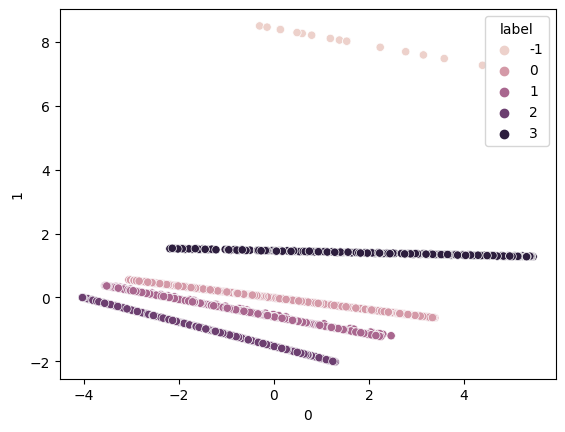

In [73]:
sns.scatterplot(data = tr_pca, x = 0, y = 1, hue = 'label')

### scale은 DBSCAN에서만 사용

In [17]:
import numpy as np

def hotellings_tsquare(trdat, tedat):
    '''
    Hotellings T-square : 공분산을 반영한 유클리디안 거리 (마할라노비스 거리)
    
    @param trdat : train data
    @param tedat : test data
    '''
    obs = trdat.shape[0]
    dim = trdat.shape[1]
    
    mu = trdat.apply(np.mean, axis=0) # 열단위 평균계산
    sinv = np.linalg.pinv(trdat.cov()) # 공분산 역행렬

    dte = (tedat-mu).values 
    
    Tsq_mat = np.zeros(tedat.shape[0])
    for i in range(tedat.shape[0]):
        Tsq_mat[i] = dte[i,:] @ sinv @ dte[i,:].transpose() # t-square distance
        
    return Tsq_mat

def bootstrap_limit(stat, alpha=0.05, bootstrap=300):
    '''
    Bootstrap sampling을 활용한 Control Limit 산출 기법
    
    @param stat : 통계량
    @param alpha : Control Limit을 정하기 위한 유의수준
    @param : bootstrap : 샘플링 횟수
    '''
    alpha = (alpha/2)*100
    alpha = 100 - alpha
    samsize = max(10000, len(stat))
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    # stat에서 samsize만큼 선택 후 75%분위수(alpha에따라 변경) 뽑기 이후 bootstrap만큼 반복 후 리스트로 만들고 평균 계산
    return limit

In [18]:
hotell_result = []
for i in range(4):
    data = train_sc[train_sc['label'] == i]
    hotell_result.append(hotellings_tsquare(data,train_sc))

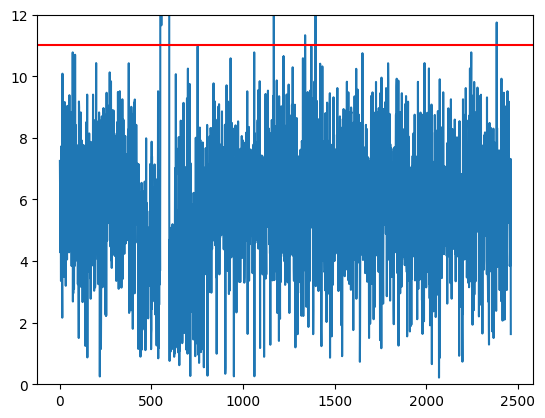

In [19]:
pd.DataFrame(hotell_result).T.min(axis=1).plot()
plt.ylim(0,12)
plt.axhline(11,color='r')

In [20]:
drop_index = np.where(pd.DataFrame(hotell_result).T.min(axis=1) < 11)

In [21]:
real_tr = tr.loc[drop_index]

In [22]:
real_label = pd.DataFrame(labels).loc[drop_index]

In [23]:
real_tr['label'] = real_label

In [24]:
real_tr

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,label
0,1.59,41.00,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...
2458,2.28,50.20,29.53,2416.0,66.84,3.34,0
2459,2.04,46.94,26.34,2155.0,63.94,3.20,0
2460,1.19,35.74,15.39,1259.0,53.99,2.70,0
2461,1.21,36.00,15.64,1280.0,54.22,2.71,0


In [25]:
hotell_result = []
for i in range(4):
    data = real_tr[real_tr['label'] == i]
    drop_data = data.drop(['label'], axis=1)
    hotell_result.append(hotellings_tsquare(drop_data,real_tr.drop('label',axis=1)))

In [34]:
pd.DataFrame(hotell_result).T.min(axis=1)

0       7.271430
1       6.383036
2       4.298220
3       6.844826
4       6.053622
          ...   
2406    4.372858
2407    5.553627
2408    3.864374
2409    7.317556
2410    1.628506
Length: 2411, dtype: float64

<Axes: >

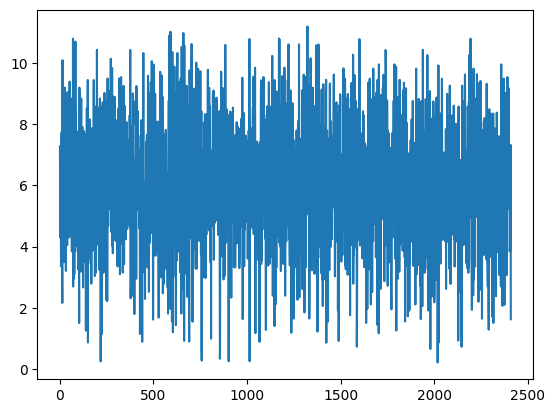

In [35]:
pd.DataFrame(hotell_result).T.min(axis=1).plot()

In [36]:
bootstrap_limit(pd.DataFrame(hotell_result).T.min(axis=1))

9.663301377274053

In [37]:
hotell_result_te = []
for i in range(4):
    data = real_tr[real_tr['label'] == i]
    drop_data = data.drop('label', axis=1)
    hotell_result_te.append(hotellings_tsquare(drop_data,test.drop('type', axis=1)))

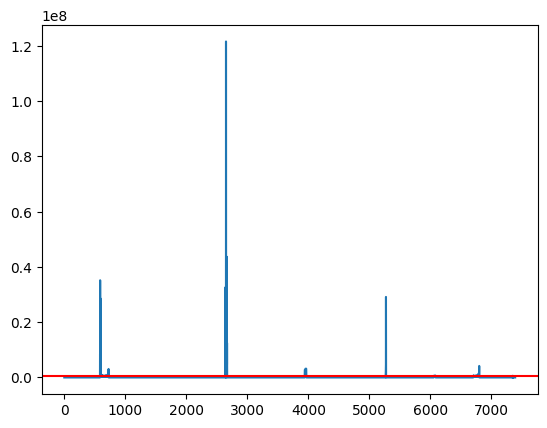

In [38]:
pd.DataFrame(hotell_result_te).T.min(axis=1).plot()
plt.axhline(bootstrap_limit(pd.DataFrame(hotell_result_te).T.min(axis=1)), color ='r')

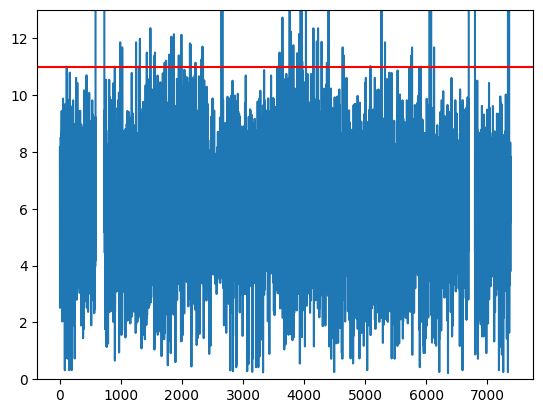

In [96]:
pd.DataFrame(hotell_result_te).T.min(axis=1).plot()
plt.axhline(bootstrap_limit(pd.DataFrame(hotell_result_te).T.min(axis=1)), color ='r')
plt.ylim(0,13)
plt.axhline(11, color='r')
plt.show()

In [40]:
pd.DataFrame(hotell_result_te).T.min(axis=1)

0       8.148127
1       5.665603
2       2.515024
3       3.578465
4       5.810233
          ...   
7384    5.590147
7385    7.833035
7386    7.357582
7387    6.600141
7388    3.821979
Length: 7389, dtype: float64

In [41]:
bootstrap_limit(pd.DataFrame(hotell_result_te).T.min(axis=1))

452677.54460548284

In [98]:
total_result = pd.DataFrame(hotell_result_te).T.min(axis=1)

In [99]:
re = pd.DataFrame(index=te.index, data = 0, columns=['label'])

In [117]:
control_limit = np.where(total_result >9.8)[0]

In [119]:
len(control_limit)

547

In [120]:
re.loc[control_limit, 'label'] = 1

<Axes: >

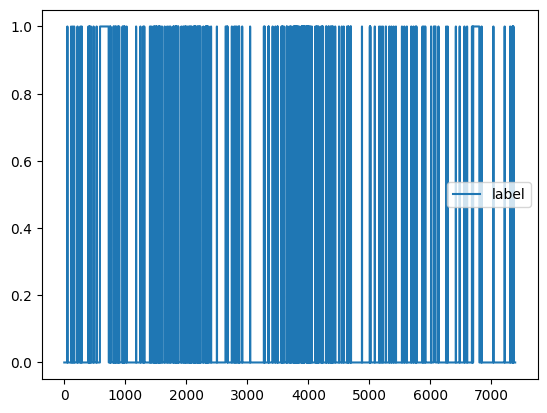

In [121]:
re.plot()

In [122]:
re.to_csv("C:/Users/user/Desktop/total_result.csv", index=False)